# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [230]:
# student details 1: David L. 0387
# student details 2: Shavit T. 1723

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
We received a dataset describing passengers of the Titanic, where each record represents a passenger with personal attributes such as age, gender, travel class, number of Number of siblings or spouse, ticket price, and point of embarkation. The learning problem is a classification task, aiming to predict whether a passenger survived the sinking (Survived) or not. 
The target variable is binary (1 = survived, 0 = not survived), and the goal is to build a model that can identify patterns and relationships between passenger profiles and their chances of survival.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [231]:
# Import necessary libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix


# Load the datasets from a CSV files
df_train = pd.read_csv('./datasets/titanic_train.csv') 
df_test = pd.read_csv('./datasets/titanic_test.csv') 

In [232]:
# Display the first 5 rows of the training dataset
df_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [233]:
# Display the first 5 rows of the test dataset
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


In [234]:
#round the Age columns to the nearest integer 
df_train['Age'] = df_train['Age'].round()
df_test['Age'] = df_test['Age'].round()

#round the Fare columns to the one decimal place
df_train['Fare'] = df_train['Fare'].round(1)
df_test['Fare'] = df_test['Fare'].round(1)


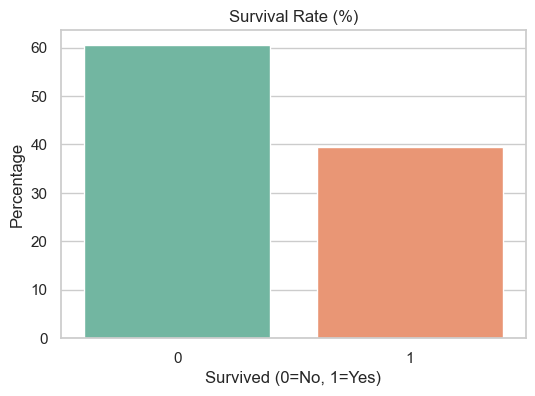

In [235]:
# --- Product 1: Target distribution (Survived) ---
survival_rate = df_train["Survived"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
sns.barplot(
    x=survival_rate.index, 
    y=survival_rate.values, 
    hue=survival_rate.index, 
    legend=False, 
    palette="Set2"
)
plt.title("Survival Rate (%)")
plt.ylabel("Percentage")
plt.xlabel("Survived (0=No, 1=Yes)")
plt.show()
# Flow stage:  Outcome Analysis – checking class distribution before feature analysis.
# Purpose:  Understand the balance of the target variable (Survived).

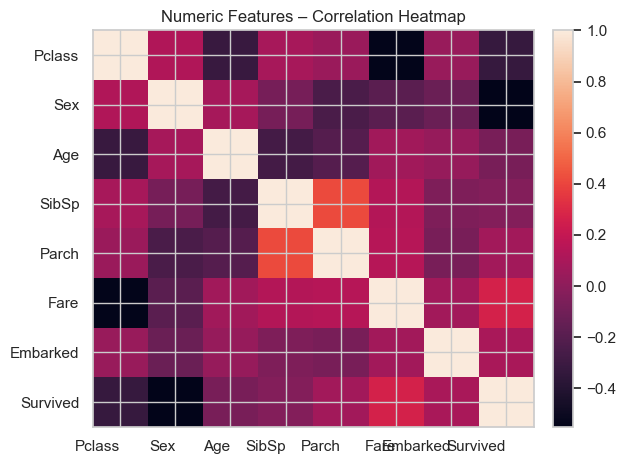

In [236]:
# ---------- (1) Correlation heatmap for numeric features ----------
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
corr = df_train[num_cols].corr()

plt.figure()
im = plt.imshow(corr, aspect="auto")
plt.title("Numeric Features – Correlation Heatmap")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=range(len(num_cols)), labels=num_cols, ha="right")
plt.yticks(ticks=range(len(num_cols)), labels=num_cols)
plt.tight_layout()
plt.show()
# Purpose: show linear relationships between numeric features and the target (Survived)
# Flow stage: feature analysis / relationship inspection

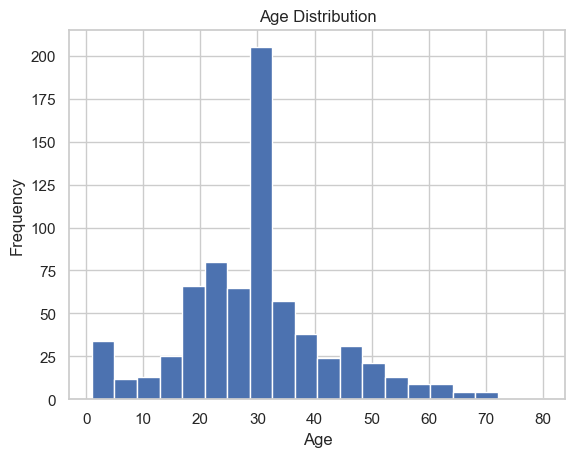

In [237]:
# --- Product 3: Age distribution ---
df_train["Age"].dropna().plot(kind="hist", bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()
# Flow stage: Feature engineering / analyzing continuous variables
# Purpose: Explore the spread of ages, detect skewness or missing values,
#          and prepare for imputation or binning if needed

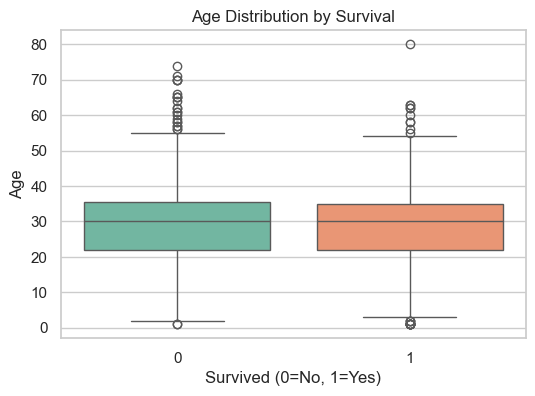

In [238]:
# Boxplot of Age by Survival (fixed for seaborn>=0.14)
plt.figure(figsize=(6,4))
sns.boxplot(
    x="Survived", 
    y="Age", 
    data=df_train, 
    hue="Survived", 
    legend=False, 
    palette="Set2"
)

plt.title("Age Distribution by Survival")
plt.xlabel("Survived (0=No, 1=Yes)")
plt.ylabel("Age")
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [239]:
# ---------------------------------------------------------
# 2) Select numeric features (all numeric columns except target)
# ---------------------------------------------------------
numeric_cols = df_train.drop(columns=["Survived"]).select_dtypes(include=[np.number]).columns.tolist()
X_train = df_train[numeric_cols].copy()
y_train = df_train["Survived"].astype(int)
X_test  = df_test[numeric_cols].copy()
y_test  = df_test["Survived"].astype(int)

print(f"[Info] Using numeric features ({len(numeric_cols)}): {numeric_cols}")

[Info] Using numeric features (7): ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [240]:
# ---------------------------------------------------------
# 3) Define search spaces
# ---------------------------------------------------------
scale_options = [False, True]

lr_C_values = [0.5, 1.0]
lr_class_weights = [None, "balanced"]

rf_n_estimators = [200, 400]
rf_max_depths   = [None, 8]

In [241]:
# ---------------------------------------------------------
# 4) 5-Fold Stratified CV across the full grid (nested loops)
# ---------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rows = []

def evaluate_config(model, apply_scaling):
    """Return mean F1 and std F1 across 5 CV folds for the given model and scaling flag."""
    f1_scores = []
    for tr_idx, val_idx in cv.split(X_train, y_train):
        Xtr_fold = X_train.iloc[tr_idx].values
        Xval_fold = X_train.iloc[val_idx].values
        ytr_fold = y_train.iloc[tr_idx].values
        yval_fold = y_train.iloc[val_idx].values

        if apply_scaling:
            scaler = StandardScaler()
            Xtr_fold = scaler.fit_transform(Xtr_fold)  # fit on training fold only
            Xval_fold = scaler.transform(Xval_fold)    # transform validation fold

        model.fit(Xtr_fold, ytr_fold)
        yval_pred = model.predict(Xval_fold)
        f1_scores.append(f1_score(yval_fold, yval_pred))

    return float(np.mean(f1_scores)), float(np.std(f1_scores))

# ---- LR branch (nested loops) ----
for scale_flag in scale_options:
    for C_val in lr_C_values:
        for cw in lr_class_weights:
            lr = LogisticRegression(
                max_iter=1000,
                C=C_val,
                class_weight=cw,
                penalty="l2",
                solver="lbfgs",
            )
            mean_f1, std_f1 = evaluate_config(lr, scale_flag)
            rows.append({
                "Alg": "LR",
                "Scale": scale_flag,
                "LR_C": C_val,
                "LR_class_weight": cw,
                "RF_n_estimators": np.nan,
                "RF_max_depth": np.nan,
                "Mean_F1": mean_f1,
                "Std_F1": std_f1,
            })

# ---- RF branch (nested loops) ----
for scale_flag in scale_options:
    for n_est in rf_n_estimators:
        for md in rf_max_depths:
            rf = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=md,
                random_state=42
            )
            mean_f1, std_f1 = evaluate_config(rf, scale_flag)
            rows.append({
                "Alg": "RF",
                "Scale": scale_flag,
                "LR_C": np.nan,
                "LR_class_weight": np.nan,
                "RF_n_estimators": n_est,
                "RF_max_depth": md,
                "Mean_F1": mean_f1,
                "Std_F1": std_f1,
            })

# Summarize CV
df_cv = pd.DataFrame(rows).sort_values(by="Mean_F1", ascending=False).reset_index(drop=True)
print("\n=== PART 3: CROSS-VALIDATION RESULTS (sorted by Mean_F1) ===")
print(df_cv)


=== PART 3: CROSS-VALIDATION RESULTS (sorted by Mean_F1) ===
   Alg  Scale  LR_C LR_class_weight  RF_n_estimators  RF_max_depth   Mean_F1  \
0   RF   True   NaN             NaN            200.0           8.0  0.760589   
1   RF  False   NaN             NaN            200.0           8.0  0.760407   
2   RF   True   NaN             NaN            400.0           8.0  0.752964   
3   RF  False   NaN             NaN            400.0           8.0  0.750490   
4   LR  False   1.0        balanced              NaN           NaN  0.742522   
5   LR  False   0.5        balanced              NaN           NaN  0.741689   
6   LR   True   1.0        balanced              NaN           NaN  0.740280   
7   LR   True   0.5        balanced              NaN           NaN  0.738166   
8   RF   True   NaN             NaN            200.0           NaN  0.733976   
9   RF  False   NaN             NaN            200.0           NaN  0.733651   
10  RF   True   NaN             NaN            400.0      

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [242]:
# -------------------------------
# Part 4: Retrain best on FULL train (same feature engineering)
# -------------------------------
best = df_cv.iloc[0].to_dict()
print(f"\n=== BEST PERMUTATION ===\n{best}")

best_alg   = best["Alg"]
best_scale = bool(best["Scale"])

if best_alg == "LR":
    best_model = LogisticRegression(
        max_iter=1000,
        C=float(best["LR_C"]),
        class_weight=None if pd.isna(best["LR_class_weight"]) else best["LR_class_weight"],
        penalty="l2",
        solver="lbfgs",
    )
else:
    best_model = RandomForestClassifier(
        n_estimators=int(best["RF_n_estimators"]),
        max_depth=None if pd.isna(best["RF_max_depth"]) else int(best["RF_max_depth"]),
        random_state=42
    )

# Apply scaling on FULL train if required
if best_scale:
    final_scaler = StandardScaler()
    Xtr_used = final_scaler.fit_transform(X_train.values)
    Xte_used = final_scaler.transform(X_test.values)
else:
    Xtr_used = X_train.values
    Xte_used = X_test.values

best_model.fit(Xtr_used, y_train.values)
print("\n[Part 4] Training completed on FULL train with the best permutation.")



=== BEST PERMUTATION ===
{'Alg': 'RF', 'Scale': True, 'LR_C': nan, 'LR_class_weight': nan, 'RF_n_estimators': 200.0, 'RF_max_depth': 8.0, 'Mean_F1': 0.7605886147395582, 'Std_F1': 0.0321314649708378}

[Part 4] Training completed on FULL train with the best permutation.


## Part 5 - Apply on test and show model performance estimation

In [243]:
# -------------------------------
# Part 5: Predict on test + quality report
# -------------------------------
y_test_pred = best_model.predict(Xte_used)

# Show first 5 predictions vs truth
preview = pd.DataFrame({
    "Survived_true": y_test.values,
    "Survived_pred": y_test_pred
}).head(5)
print("\n[Part 5] First 5 test predictions:\n", preview)

# Metrics
print("\n=== TEST SET EVALUATION ===")
print("F1(test):", f1_score(y_test, y_test_pred))
print("\nClassification report:\n", classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))


[Part 5] First 5 test predictions:
    Survived_true  Survived_pred
0              0              0
1              0              0
2              0              0
3              0              1
4              1              1

=== TEST SET EVALUATION ===
F1(test): 0.8173913043478261

Classification report:
               precision    recall  f1-score   support

           0      0.888     0.941     0.914       118
           1      0.870     0.770     0.817        61

    accuracy                          0.883       179
   macro avg      0.879     0.856     0.865       179
weighted avg      0.882     0.883     0.881       179

Confusion matrix:
 [[111   7]
 [ 14  47]]
